In [1]:
import open3d as o3d
import MDAnalysis as mda
from numpy import *
import os
import numpy as np
from pylab import *
import igl
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import time
import glob

style.use("seaborn-poster")
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
from scipy.spatial import ConvexHull
import umap
import mdtraj


import mdtraj
import pandas as pd
import seaborn as sns

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/liam/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]



resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))
#get universes 
h2ou=[]
pegu=[]

for i in range(len(h2ogros)):
    h2ou.append(mda.Universe(h2ogros[i],h2otrjs[i]))
    #fix resids immediately
    h2ou[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
for i in range(len(peggros)):
    pegu.append(mda.Universe(peggros[i],pegtrjs[i]))
    #fix resids immediately
    pegu[i].select_atoms("protein or resname CH6").residues.resids = resids_proper
    
    
#compile all the systems in one list
systems = [h2ou,pegu]
system_names = ['No-PEG','PEG']
#[]
#[tol-darkgreen,tol-darkblue,tol-bottompurple]
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
# Let's set up the selections for each trajectory by chain

# i want to make a list that has the sh2 domains selected in each sublist so that each one has 6 selections.
h2ou_fullprotein=[]
pegu_fullprotein=[]

h2ou_fullprotein_string=[]
pegu_fullprotein_string=[]


h2ou_notail=[]
pegu_notail=[]


h2ou_notail_string=[]
pegu_notail_string=[]


for i in range(len(h2otrjs)):
    h2ou_notail.append(h2ou[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    h2ou_notail_string.append("(protein or resname CH6) and resid 1:228")
    h2ou_fullprotein.append(h2ou[i].select_atoms("(protein or resname CH6)"))
    h2ou_fullprotein_string.append("(protein or resname CH6)")
    
for i in range(len(pegtrjs)):
    pegu_notail.append(pegu[i].select_atoms("(protein or resname CH6) and resid 1:228"))
    pegu_notail_string.append("(protein or resname CH6) and resid 1:228")
    pegu_fullprotein.append(pegu[i].select_atoms("(protein or resname CH6)"))
    pegu_fullprotein_string.append("(protein or resname CH6)")

fullprotein_selections=[h2ou_fullprotein,pegu_fullprotein]
fullprotein_selections_string=[h2ou_fullprotein_string,pegu_fullprotein_string]
notail_selections = [h2ou_notail,pegu_notail]
notail_selections_string = [h2ou_notail_string,pegu_notail_string]



/home/liam/anaconda3/lib/python3.9/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)
/home/liam/anaconda3/lib/python3.9/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details a

In [5]:
def getAtomicS(u,pocketAtoms,mySel="protein"):
    atomicSelection = u.atoms[pocketAtoms]
    return atomicSelection


def PCDFromArray(myArray):
    # Open3D works with .xyz files, so we save our list as that type
    f = open('xyz.xyz',"w")
    for i in range(len(myArray)):
        f.write(str(myArray[i]).replace("[","").replace("]",""))
        f.write("\n")
    f.close()
    
    #Load in the file as a point cloud data type
    pcd=o3d.io.read_point_cloud("xyz.xyz")
    
    return pcd

def NWatersTimeSeries(u,pocketAtoms,stride=100,EQPOINT=250):
    
    pocketSelectionString = "protein and name CA and ("
    for i in range(len(pocketAtoms)):
        pocketSelectionString+= "resid " + str(pocketAtoms[i])+" or "
    pocketSelectionString=pocketSelectionString[:-4]+")"

    a = u.select_atoms(pocketSelectionString).atoms.indices    
    
    #Get the pocket selection
    pocket=getAtomicS(u,a)

    #Make lists
    nWaters=[]

    # Loop through the trajectory
    #for t in range(int(EQPOINT/stride),int(len(u.trajectory)/stride)):
    for t in u.trajectory[EQPOINT:len(u.trajectory):stride]:
        waterSelection = u.select_atoms("not (protein or resname CH6)",updating = True)
        waterPositions=waterSelection.positions

        #Update frame and get pocket positions
        pocketPositions=pocket.atoms.positions
        
        pcd = PCDFromArray(pocketPositions)

        convexHull,_=pcd.compute_convex_hull()
        convexHull.orient_triangles()
        
        waterWinding = igl.fast_winding_number_for_meshes(asarray(convexHull.vertices),asarray(convexHull.triangles),double(waterPositions))

        nWaters_singletime = len(where(abs(waterWinding) > 0.5)[0])
        nWaters.append(nWaters_singletime)


    return nWaters


importantResids = [14,42,43,44,46,59,62,63,64,65,66,69,70,91,93,95,109,143,144,145,146,148,161,163,177,181,197,198,199,213,214,215]


all_nwaters=[]

for i in range(len(systems)):
    sub=[]
    for j in range(len(systems[i])):
        sub.append(NWatersTimeSeries(systems[i][j],importantResids,stride = 1))
    all_nwaters.append(sub)
    
    
    

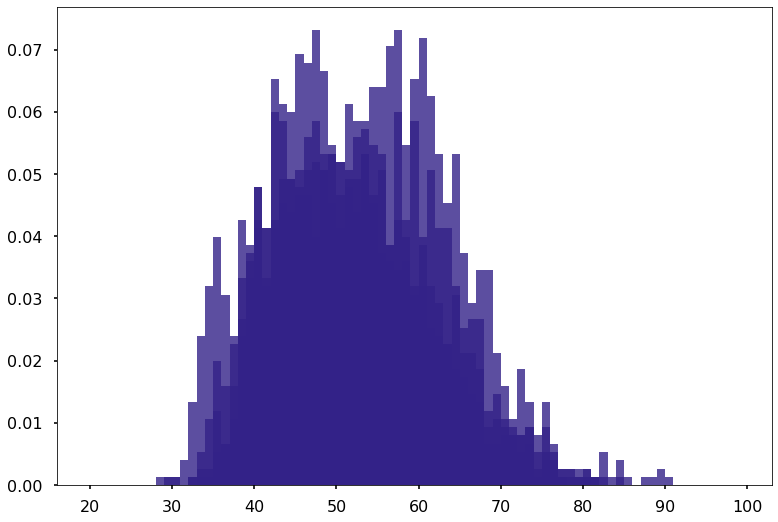

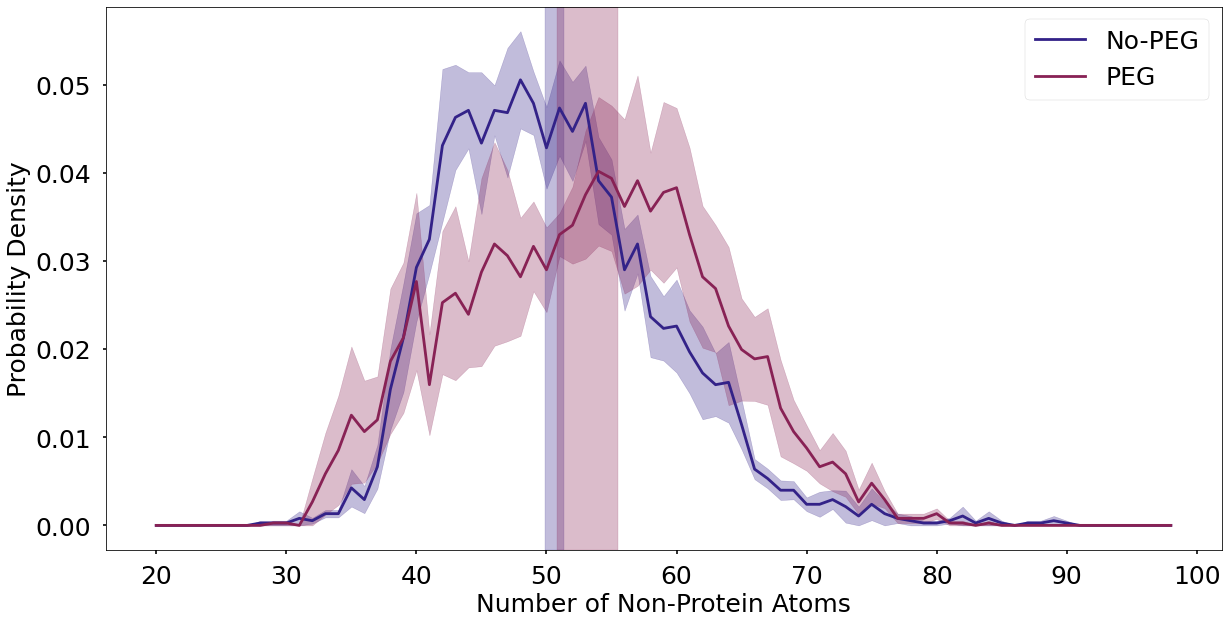

In [6]:

all_nwaters_hists=[]

for i in range(len(all_nwaters)):
    sub=[]
    for j in range(len(all_nwaters[i])):
        a=hist(all_nwaters[i][j],bins = arange(20,100,1),density = True,alpha = 0.8,color= colourScheme[0],label = system_names[0])
        sub.append(a[0])
    all_nwaters_hists.append(sub)
    
system_avg_nwaters=[]
system_sem_nwaters=[]

for i in range(len(all_nwaters)):
    system_avg_nwaters.append(mean(all_nwaters_hists[i],axis = 0))
    system_sem_nwaters.append(scipy.stats.sem(all_nwaters_hists[i],axis = 0))
    
    
    
    

trjmeans = []
for i in range(len(all_nwaters)):
    sub = []
    for j in range(len(all_nwaters[i])):
        sub.append(mean(all_nwaters[i][j]))
    trjmeans.append(sub)
    
actualMean= [mean(trjmeans[0]),mean(trjmeans[1])]
actualSem = [scipy.stats.sem(trjmeans[0]),scipy.stats.sem(trjmeans[1])]



figure(figsize = (20,10))
plot(arange(20,100,1)[:-1],system_avg_nwaters[0],color = colourScheme[0],label = system_names[0])
plot(arange(20,100,1)[:-1],system_avg_nwaters[1],color = colourScheme[1],label = system_names[1])


fill_between(arange(20,100,1)[:-1], system_avg_nwaters[0] - system_sem_nwaters[0],system_avg_nwaters[0] + system_sem_nwaters[0],color = colourScheme[0],alpha = 0.3)
fill_between(arange(20,100,1)[:-1], system_avg_nwaters[1] - system_sem_nwaters[1],system_avg_nwaters[1] + system_sem_nwaters[1],color = colourScheme[1],alpha = 0.3)


xlabel("Number of Non-Protein Atoms",fontsize = 25)
ylabel("Probability Density",fontsize = 25)
#xlim(2,32)
#title("Number of Waters Inside the Chromophore Pocket",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)

legend(fontsize = 25)



axvspan(actualMean[0] - actualSem[0],actualMean[0]+actualSem[0], color = colourScheme[0], alpha = 0.3)
axvspan(actualMean[1] - actualSem[1],actualMean[1]+actualSem[1], color = colourScheme[1], alpha = 0.3)


#savefig("nWaters.png",dpi = 600)
#savefig("nWaters.png",dpi = 600)

In [7]:
save("nWatersInConvexHullOfCAOfImportantResidues.npy",all_nwaters)